# Dyadic Spectral and Cross-Spectral Analysis
##### Matthew Vowels, Laura Vowels and Nathan Wood

In [161]:
# imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from scipy import signal
from sklearn.linear_model import LinearRegression
from scipy.stats import circmean



# 0. Why? Background and Motivation.

##### What are cycles and what is periodic fluctuation? 

Any phenomenon that rises and falls at a regular frequency.

##### Why is it useful to consider periodic fluctuation in time series? 

1. Many phenomena exhibit perdiodic fluctuation (social, biological, natural, financial etc.)
2. Periodic fluctuations will conflict with any linear relationships we are interested in.
3. Understanding periodicity gives us insight into the natural 'rhythm' of a phenomenon. It can be used to uncover additional relationships between phenomena.


#####  What are we proposing?

To undertake DFT/FFT to analyse the time series for periodic fluctuation. High order polynomials may be able to capture such fluctuations but these are just are overfitting to an underlying structure in the data, and do not account for varying phase.


##### What can we use it for?

- Identifying periodicity. 
- Building temporal models of phenomena (e.g. for prediction)
- Acquiring spectral coefficients (corresponding with amplitudes) for purposes of downstream analyses.

##### How often do we need to sample data for this method?
Depends as much on the theory behind the phenomenon as it does for the analysis. The analysis is only limited by the principle tenets of information theory, as everything is. The sampling should be REGULAR (i.e. no good sampling two days apart to get information on a cycle that occurs once per month).


##### How many sample points do we need?
Assuming we are sampling frequently enough, then we should aim to capture more than 3 cycles, although this really depends on the effect size (i.e. amplitude).

##### How do we measure our variables for best results?
VAS, Likert, at regular intervals.


### Define some terms:
- Frequency - the number of cycles in a given time period.

- Period - the time between the beginning and end of a cycle at a certain frequency.

- Amplitude - the one-sided peak level of a periodic signal.

- Phase - for a given frequency, at what point in the cycle does it start?

- Sampling frequency - how often we acquire data.

- Nyquist limit/frequency - half the sampling frequency. This is the highest frequency of periodicity that we can hope to recover for a given sampling frequency.

- Aliasing - when a frequency higher than the Nyquist limit is `reflected' into the lower frequency range. 

- Ergodicity - for our purposes, we use it to describe a system for which the behaviour does not change over the course of measurment. 

- Frequency Spectrum - a scale describing the amplitudes or power across frequency in a signal.

- Spectral analysis - a means to decompose a time series into its constituent spectral components.

- Cross-spectral analysis - a means to compare TWO time series and measure the degree of similarity in the frequency domain.

- DFT - Discrete Fourier Transform - a means to undertake spectral analysis. It transforms a discrete time series into complex coefficients. Sometimes referred to as FFT (Fast Fourier Transform) which is the algorithmic implementation.

- Power spectrum - the squared magnitude of the amplitude/frequency spectrum.

- Window - a segment of time.

- Window function - an 'envelope' over the window/segment. Hann, Blackman/Harris, Hamming etc.

#### See how regression fails to capture this structure:

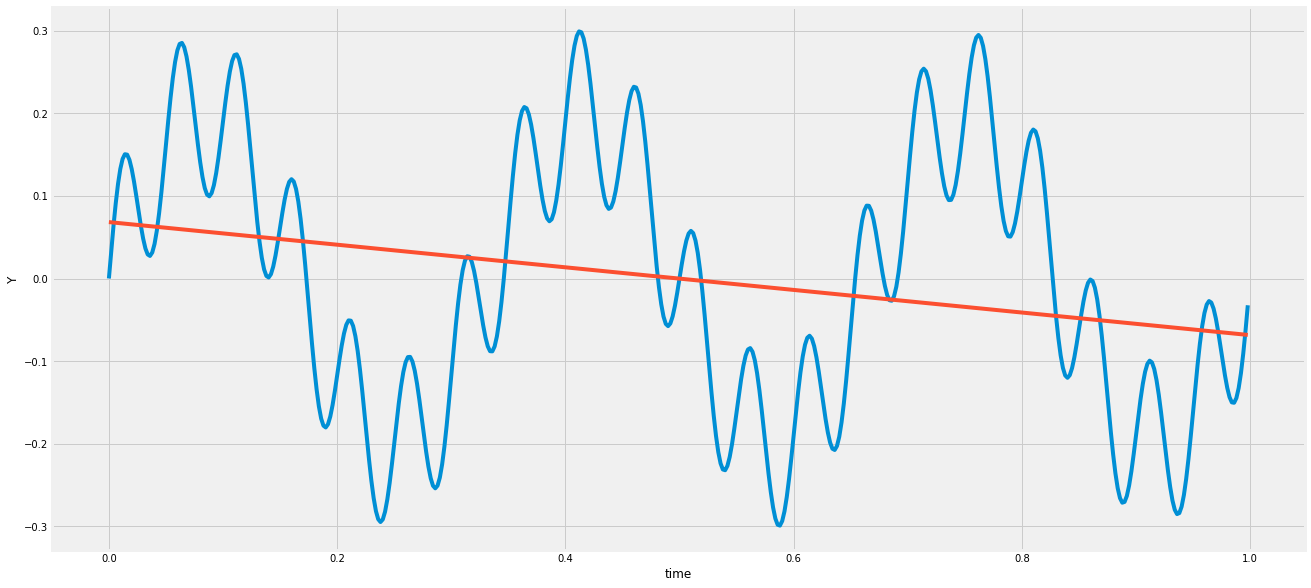

In [2]:
# create time index (between 0 and 1) with same number of time points as sample dataset. Assume we have 2 months time scale
Nt = 500
time_index = np.linspace(0,1-(1/Nt),Nt)
Fs = 30 # sampling frequency in samples per month

# sample time series with cycles at once per month
x1 = 0.1 * np.sin(2*time_index*np.pi*20) + 0.2 * np.sin(2*time_index*np.pi*3)

#x1 = 0.6 * time_index + 0.1 * np.sin(2*time_index*np.pi*20) + 0.2 * np.sin(2*time_index*np.pi*3)

y = x1.reshape((-1, 1))
x = time_index.reshape((-1, 1))
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)
plt.figure(figsize=(20,10))
plt.plot(time_index, x1)
plt.plot(time_index, y_pred)
plt.xlabel('time')
plt.ylabel('Y')
plt.show()

# 1. Fourier

We need a way to represent time series in terms of fundamental basis functions. Ideally we need to be able to represent ANY time series with these basis functions. 


Fourier's theorem states that any periodic waveform may be represented as an infinite sum of sines and cosines (recall that cosine is a sine wave shifted in phase by 90 degrees).

We make an assumption that our time series is periodic (even if it isn't) in order to decompose it into sines and cosines. Let's see if we can represent a square wave using only sine waves... 

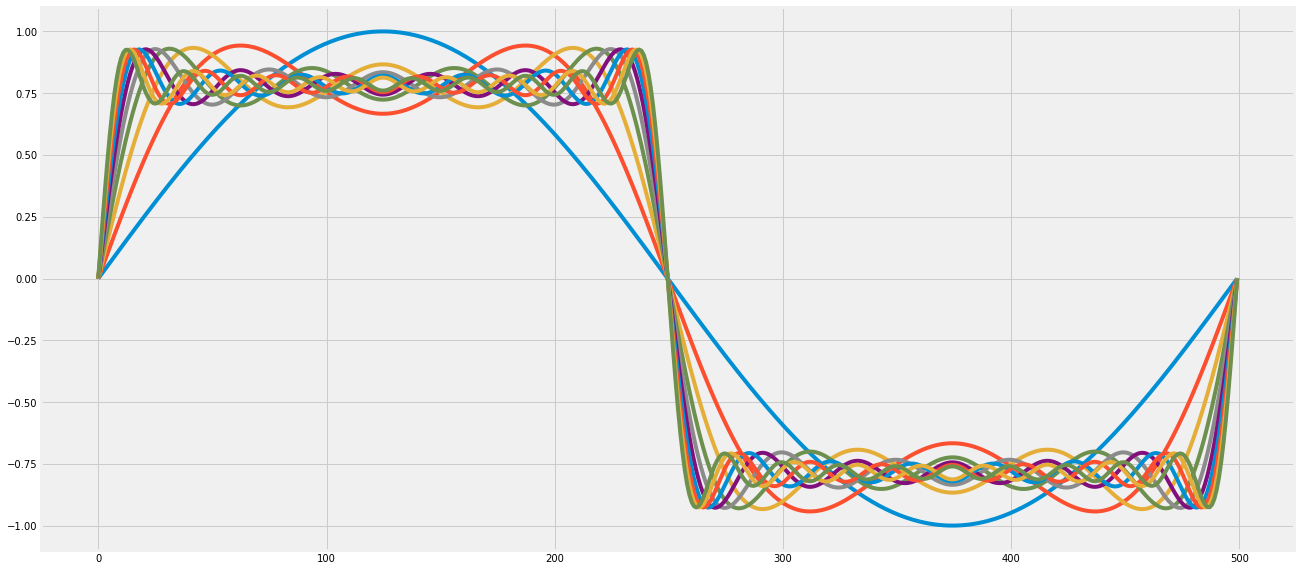

In [6]:
# this shows the cumulative sum of sine waves of increasing order
num_sines = 10
points = 500
t = np.linspace(0,2*np.pi,points)
y = np.zeros((num_sines,len(t)))
x = np.zeros(len(t));

for k in range(0,num_sines):
   x += np.sin(((2*k)+1)*t)/((2*k)+1)
   y[k,:] = x
    
plt.figure(figsize=(20,10))
for i in range(0, num_sines):
    plt.plot(y[i,:])
     
plt.show()

We are using sine waves as basis functions to represent our time series. In the limit, we experience 'Gibb's phenomenon' which affects our ability to represent discontinuities. In practice this is not an issue.

The spectral 'coefficients' are the amplitudes of the sines and cosine waves in this series.

Let's say we have a theory that some variable Y varies once a month, and we have 60 days worth of data, sampled once daily.

In [23]:
# create time index (between 0 and 1) with same number of time points as sample dataset. 
# Assume we have 2 months time scale
Nt = 60
time_index = np.linspace(0,1-(1/Nt),Nt) # this puts our x axis in arbitrary time units of 1/60 
Fs = 30 # sampling frequency in samples per month


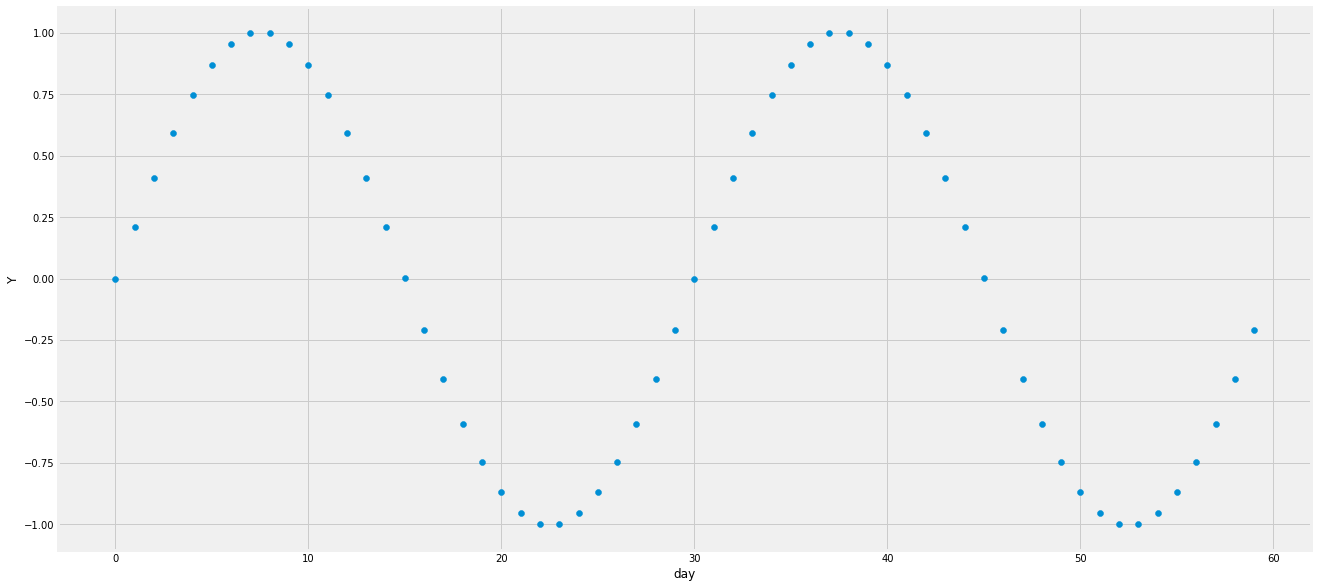

In [24]:
# sample time series with cycles at once per month
x1 = np.sin(2*time_index*np.pi*2)

# see what happens if you add noise? x1 = np.sin(2*time_index*np.pi*2) + 0.2 * np.random.randn(len(time_index))

# rescale to be between -1 and 1
x1 = 2 *( x1-x1.min())/(x1.max() - x1.min()) - 1
plt.figure(figsize=(20,10))
plt.scatter(time_index*Nt,x1)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

Note that there is no 'phase offset to this'. If we want to, say, delay the rise of the wave (at this SPECIFIC frequency) by 5 days, then we need to understand the relationship between 5 days and the total period of the wave of 2*pi. e.g. our frequency is 30 days (once per month = 2*pi) then 5 days is 5/30 * 2pi.

The important thing to understand here is that 'phase' is specific to the wave, not the overall time series. If we want to delay the entire timeseries, then we add our shift to 'time_index' directly. 

In [25]:
days_delay = 15 # for specific frequency
# sample time series with cycles at once per month
x2 = np.sin(2*time_index*np.pi*2 - (days_delay/30)*2*np.pi ) 

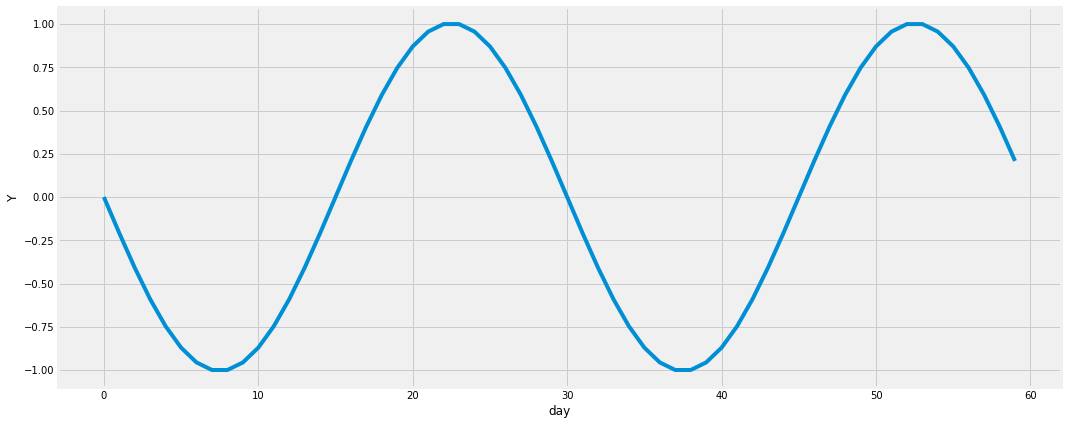

In [26]:
# rescale to be between -1 and 1
x2 = 2 *( x2-x2.min())/(x2.max() - x2.min()) - 1
plt.figure(figsize=(16,7))
plt.plot(time_index*Nt,x2)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

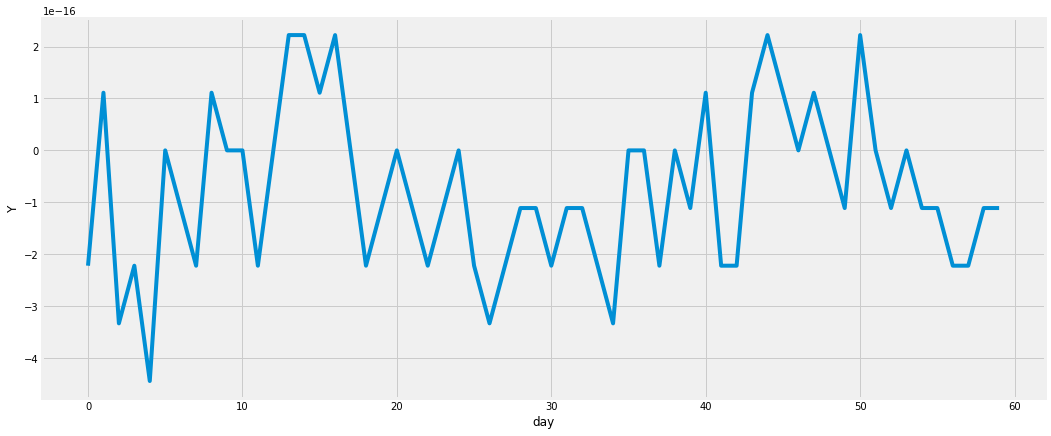

In [29]:
# if the waves are in inverse polarity (i.e. pi radians out of phase) they will completely canel:
plt.figure(figsize=(16,7))
plt.plot(time_index*Nt,x2+x1)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

# notice the y-axis scale!!

See above that the rise of our wave has now been delayed by days_delay. 

# 2. Spectral Analysis with FFT
Now let's use an algorithmic implementation of the 'Fourier Transform' to decompose our time series into its constituent sine and cosine coefficients. This tells us which frequencies are in our wave. This TRANSFORM is not destroying information, just transforming it from the time domain to the frequency domain. We move from *time series* to *frequency spectrum*.

(31,)
(60,)


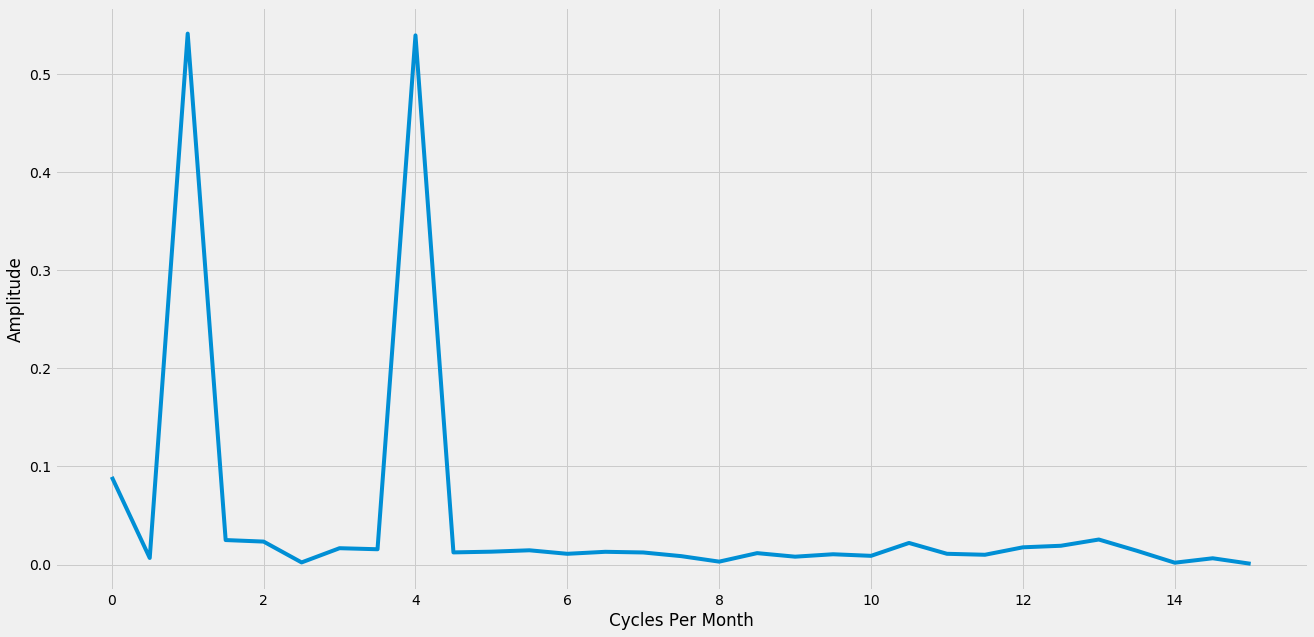

In [430]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
print(f.shape)
fft1 = np.fft.fft(x1)
print(fft1.shape)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
plt.figure(figsize=(20,10))
plt.plot(f, fft2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

In [443]:
(fft1[0:int(Nt/2)+1])


array([-2.67885664+0.00000000e+00j,  0.02972573-1.97494526e-01j,
        0.12803467-1.62316212e+01j,  0.60681639-4.36795304e-01j,
       -0.42312316-5.58692844e-01j,  0.04683095+4.34594982e-02j,
        0.09734065-4.88987251e-01j,  0.45240856-1.14597471e-01j,
        0.19781079-1.61773536e+01j,  0.22873952+2.91398936e-01j,
       -0.38619369-6.94760923e-02j, -0.28237918-3.30565747e-01j,
        0.3216041 -6.10089791e-02j, -0.34219182+1.83888606e-01j,
        0.2004978 +3.08679977e-01j, -0.14782997+2.08824102e-01j,
       -0.07889506+3.84255556e-02j, -0.3030977 -1.70661717e-01j,
       -0.22116314+9.14603256e-02j, -0.28751496-1.25088057e-01j,
       -0.16150844-2.10146712e-01j,  0.19613455-6.29279641e-01j,
       -0.31102122+1.03324233e-01j,  0.03246714+2.95985999e-01j,
       -0.00866575-5.25684685e-01j,  0.42370726-3.85903265e-01j,
       -0.40517985-6.47629972e-01j, -0.42058257+3.16815179e-03j,
       -0.02329486-5.02993168e-02j,  0.15069334+1.16821061e-01j,
       -0.02196934-2.7755

See above that we have 1 spike at a frequency of once per month (care needs to be taken in setting the x-axis units). Decide on a metric and stick to it. We have gone with 'cycles per MONTH'.

Note, also, the operations. It is not critical to understand this, but the FT gives an 'even' spectrum (one which is mirrored around the 'y' axis) and it also gives complex coefficients (with imaginary numbers). We therefore take only one half of the spectrum, take the ABS value, and multiply it by 2 to compensate for the fact we lost half the energy when taking only half the spectrum.

What happens if our signal does not have a full number of cycles (i.e. it contains discontinuities) like this:

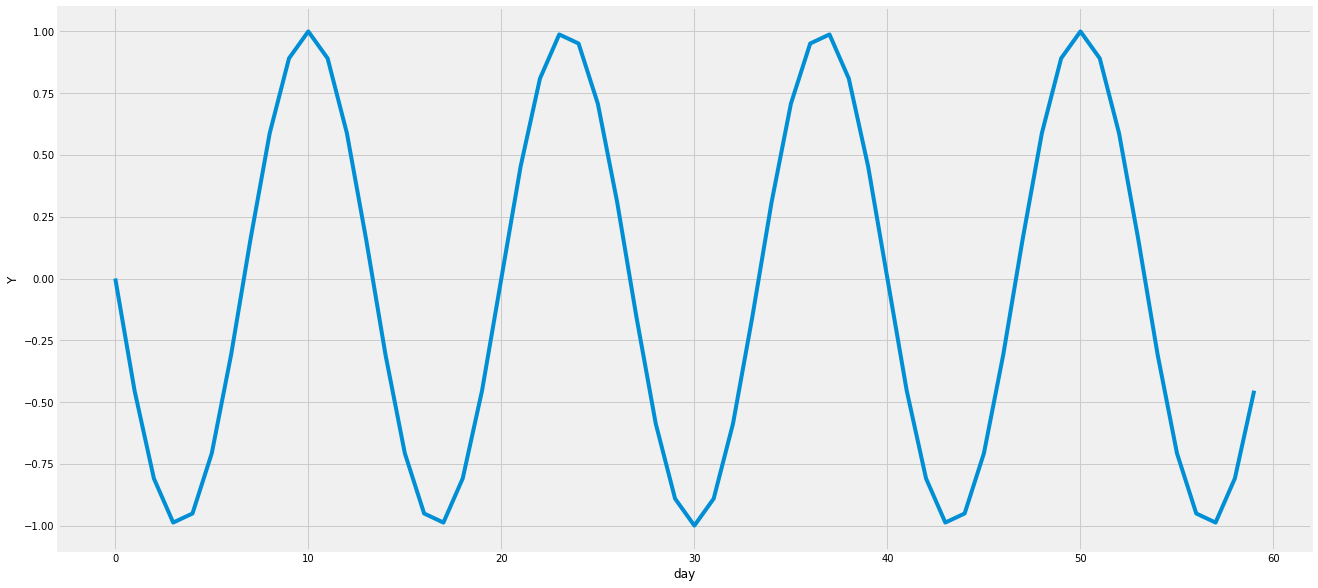

In [42]:
# sample time series with cycles at once per month
x1 = np.sin(2*time_index*np.pi*4.5 - (days_delay/30)*2*np.pi ) 


# and see what happens if we add noise x1 = np.sin(2*time_index*np.pi*4.5 - (days_delay/30)*2*np.pi ) + 0.2*np.random.randn(len(time_index))

# rescale to be between -1 and 1
x1 = 2 *( x1-x1.min())/(x1.max() - x1.min()) - 1
plt.figure(figsize=(20,10))
plt.plot(time_index*Nt,x1)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

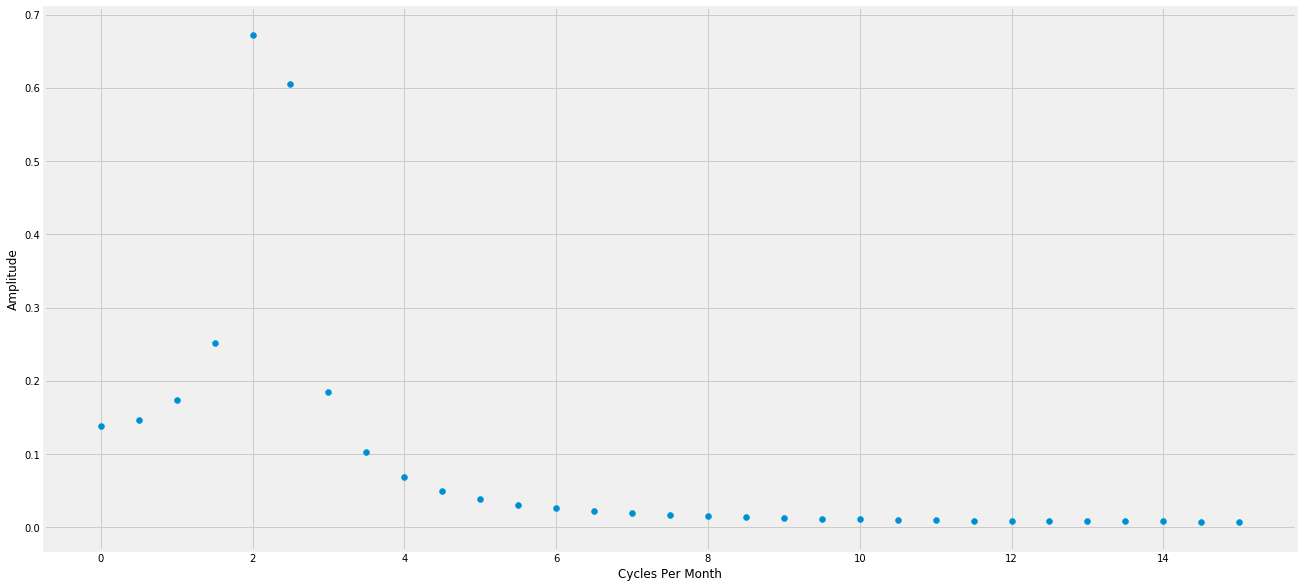

In [43]:

f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(x1)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
plt.figure(figsize=(20,10))
plt.scatter(f, fft2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

See now that the spectrum is more ambiguous. Remember the square wave which had lots of discontinuities? The same thing is happening here. We need many more frequencies to represent this wave. WE might know it is only a sine wave, but the algorithm has to transform exactly what it sees... To deal with this we use WINDOWING but this is a compromise. We will come back to this later.

Now let's see what happens with a more complex wave...

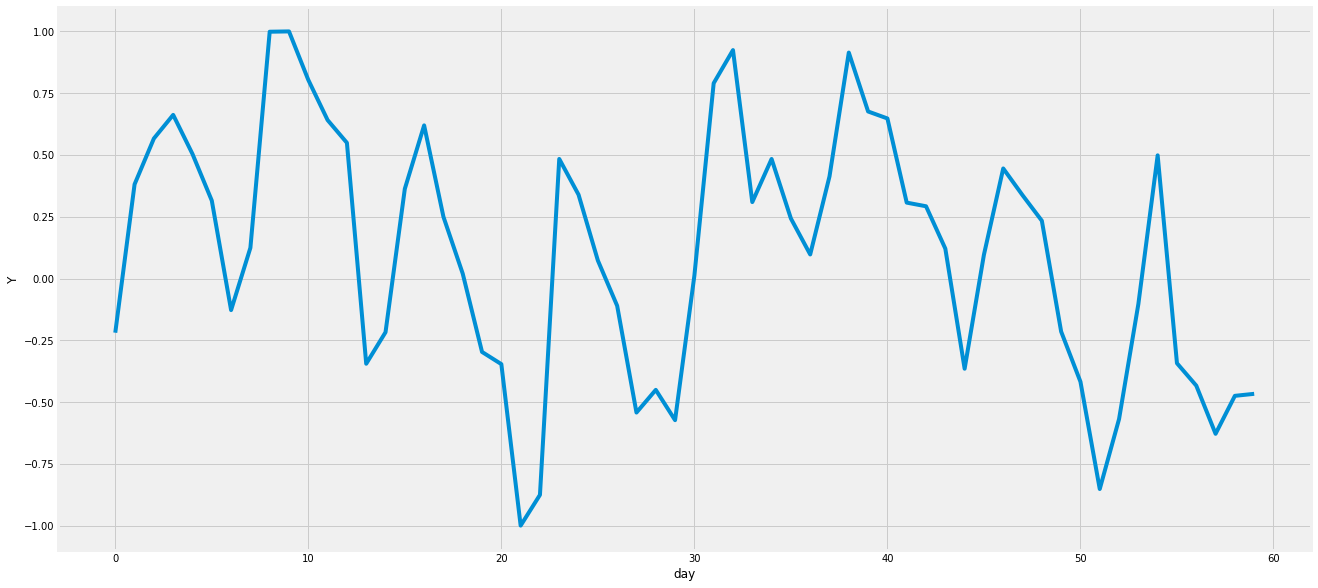

In [44]:
# sample time series with cycles at once per month, 4 times per month and twice a week and some noise
x1 = np.sin(2*time_index*np.pi*2) + np.sin(2*time_index*np.pi*8) + 0.5*np.sin(2*time_index*np.pi*16) + 0.4*np.random.randn(Nt)
# notice that our once per month is written here as twice every two months, because of our time index,
# which is 60 days of data (i.e. two months) squashed into 0 - 1. 


# rescale to be between -1 and 1
x1 = 2 *( x1-x1.min())/(x1.max() - x1.min()) - 1

plt.figure(figsize=(20,10))
plt.plot(time_index*Nt,x1)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

This wave looks very chaotic. Is there order in this chaos?

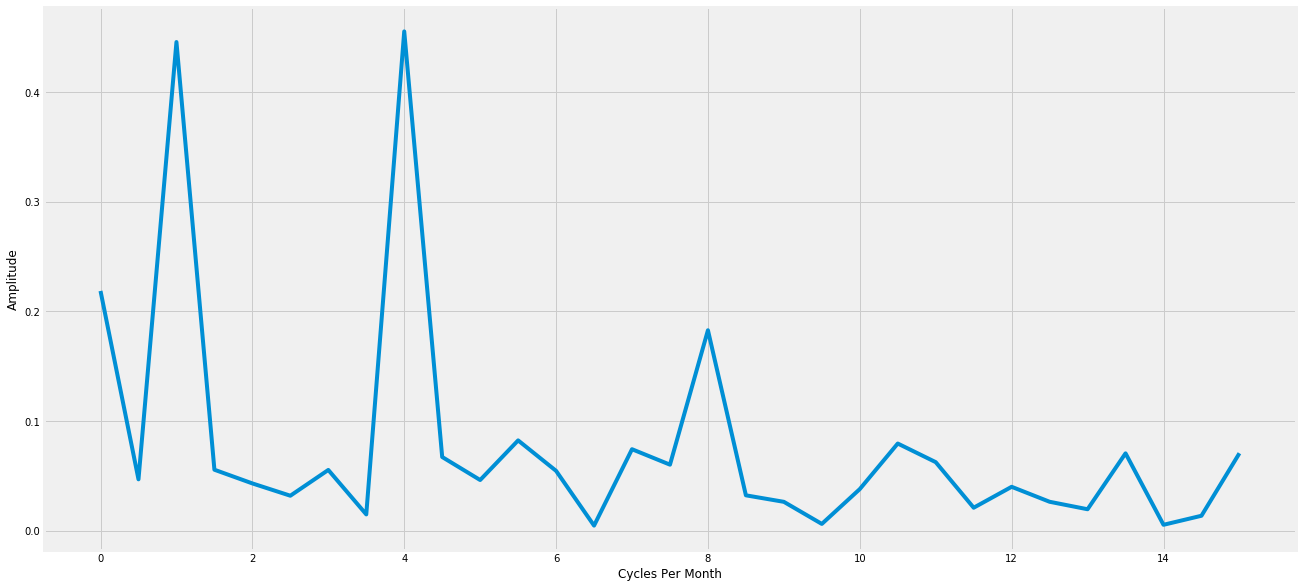

In [45]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(x1)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
plt.figure(figsize=(20,10))
plt.plot(f, fft2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

Yep... there is! We have recovered the frequencies of once per month, 4 times per month, and twice per week. Note that the more data we have, the more accurate the estimation of the frequency components will be, even if we have the same level of noise/'random variance'.

Note that we can use the inverse FFT to return to the original time series (so long as we KEEP the phase information). This is a therefore TRANSFORM, not a model. No data/information is lost.

# 3. Cross-spectral analysis with FFT

Let's imagine we have two time series, x1 and x2 

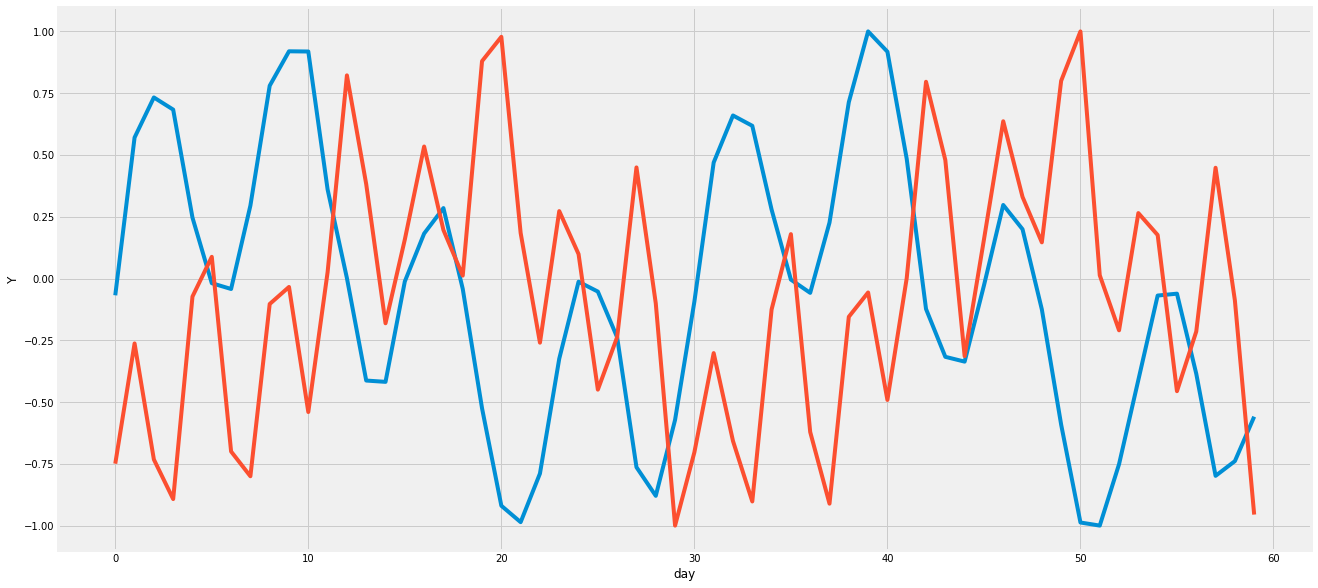

In [94]:
# sample time series both with cycles (once a week and once per month) with phase offset and some noise
# the second series will also have an additional cycle of twice per week

x1 = np.sin(2*time_index*np.pi*2) + np.sin(2*time_index*np.pi*8) + 0.1 * np.random.randn(Nt)

x2 =  np.sin(2*time_index*np.pi*16) + np.sin(2*time_index*np.pi*2 - (10/30)*2*np.pi) + 0.5 * np.sin(2*time_index*np.pi*8 - (10/30)*2*np.pi) + 0.1 * np.random.randn(Nt) 

# rescale to be between -1 and 1
x1 = 2 *( x1-x1.min())/(x1.max() - x1.min()) - 1
x2 = 2 *( x2-x2.min())/(x2.max() - x2.min()) - 1

plt.figure(figsize=(20,10))
plt.plot(time_index*Nt,x1)
plt.plot(time_index*Nt,x2)
plt.xlabel('day')
plt.ylabel('Y')
plt.show()

The two signals share two of the same frequencies (once a week and once per month) apart from the second series which has an addition component. For the components that are shared there are phase offsets. Can we determine that they share the same frequencies after all...?

Yes! CPSD is effectively a measure of correlation in the power spectra of the two signals.
Lets first see what the ffts for the two signals look like:

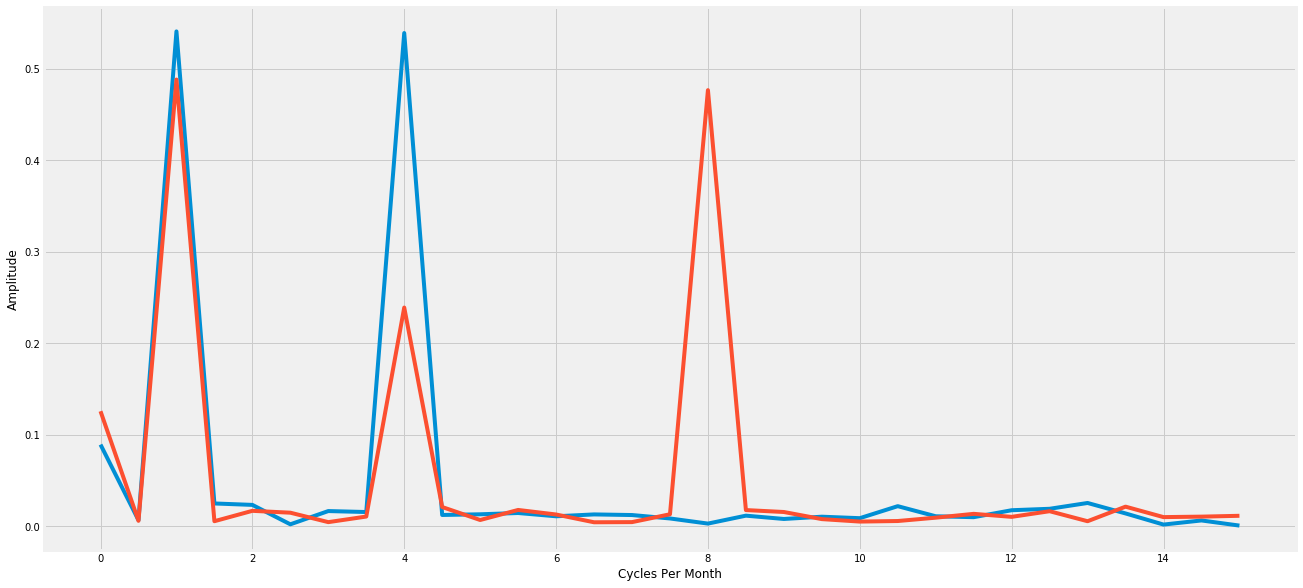

In [95]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt
fft1 = np.fft.fft(x1)
fft2 = 2*np.abs(fft1[0:int(Nt/2)+1]/Nt)
fft3 = np.fft.fft(x2)
fft4 = 2*np.abs(fft3[0:int(Nt/2)+1]/Nt)
plt.figure(figsize=(20,10))
plt.plot(f, fft2)
plt.plot(f, fft4)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

We see that the second signal has the additional component at  times per month (or twice per week) that the other series does not. Will this be reflected in the CPSD...? Nope! because it isn't shared between series!

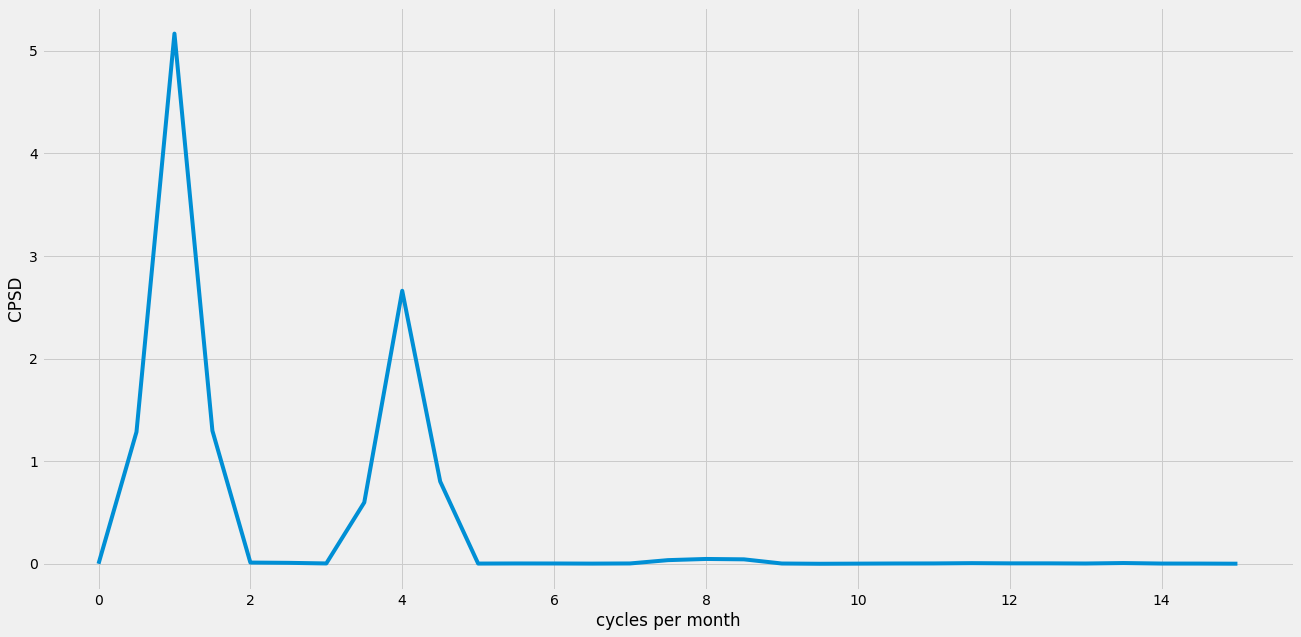

In [219]:
f1, Pxy = signal.csd(x1, x2, nperseg=Nt)
plt.figure(figsize=(20,10))
plt.plot(f, np.abs(Pxy))
plt.xlabel('cycles per month')
plt.ylabel('CPSD')
plt.show()

# 4. Phase and Polar Histograms

We breifly mentioned (and ignored) the fact that the output of a FFT is complex (i.e. it is in $a + jb$ form) where j is the sqrt(-1). We got around this by just taking the magnitude of $a + jb$ which is $(a^2 + b^2)^{0.5}$. The complex representation has information about the phase:

$\angle (a+jb) = \arctan (b/a) $

but we can also use the numpy.angle() function

In [220]:
fft1 = np.fft.fft(x1) # starting from the original fft...
fft2 = (fft1[0:int(Nt/2)+1]/Nt)  # take the spectrum half that we are concerned with 
# we don't have to worry about the *2 because phase estimates are not affected by amplitude

print(fft2.shape)
fft2

# notice we have 31 complex numbers corresponding with spectral coefficients:

(31,)


array([-0.04464761+0.00000000e+00j,  0.00049543-3.29157544e-03j,
        0.00213391-2.70527020e-01j,  0.01011361-7.27992173e-03j,
       -0.00705205-9.31154740e-03j,  0.00078052+7.24324970e-04j,
        0.00162234-8.14978752e-03j,  0.00754014-1.90995785e-03j,
        0.00329685-2.69622559e-01j,  0.00381233+4.85664893e-03j,
       -0.00643656-1.15793487e-03j, -0.00470632-5.50942911e-03j,
        0.00536007-1.01681632e-03j, -0.0057032 +3.06481010e-03j,
        0.00334163+5.14466629e-03j, -0.00246383+3.48040171e-03j,
       -0.00131492+6.40425927e-04j, -0.00505163-2.84436195e-03j,
       -0.00368605+1.52433876e-03j, -0.00479192-2.08480095e-03j,
       -0.00269181-3.50244519e-03j,  0.00326891-1.04879940e-02j,
       -0.00518369+1.72207055e-03j,  0.00054112+4.93309998e-03j,
       -0.00014443-8.76141141e-03j,  0.00706179-6.43172109e-03j,
       -0.006753  -1.07938329e-02j, -0.00700971+5.28025298e-05j,
       -0.00038825-8.38321947e-04j,  0.00251156+1.94701769e-03j,
       -0.00036616-4.6259

Now we can look at the angles/phase (in $\pi$ RADIANS) for each of the coefficients. But be careful - we only really care about the phase of the components that are of significant amplitude... The rest are noisy.

In [221]:
np.angle(fft2)

array([ 3.14159265, -1.42140353, -1.56290851, -0.62390095, -2.21898161,
        0.74807541, -1.37429918, -0.24808708, -1.5585693 ,  0.90528723,
       -2.96359696, -2.277741  , -0.18747443,  2.64848655,  0.99474954,
        2.18681545,  2.6883615 , -2.62877909,  2.74946662, -2.73122679,
       -2.22606466, -1.2686577 ,  2.82085381,  1.46154166, -1.58727953,
       -0.738738  , -2.12985199,  3.13406003, -2.00451102,  0.65944987,
       -3.14159265])

In order to demonstrate how this can be useful. Let's create some data simulating participants that all share the same periodic cyclicity, but that differ in their phase. 

But first... let's just have a think about phase 'wrapping'. $2\pi$ = 6.283... but in terms of our periodic functions, this is the same as 0.  This means that is it potentially incorrect to think of phase discrepancies that differ by $2\pi$ as different from each other. Polar plots can be useful here, and we will use polar histograms to visualise the distribution of phase  for each spectral component.

One more thing - taking the arithmetic mean of phase does not make sense for the same reason it doesn't work to distinguish between a phase of 0 and a phase of $2\pi$. Luckily, circular statistics exists, and we can use circular means.

What follows depicts a typical full workflow of spectral analysis, including spectral averages, cross-spectral averages, polar histograms and circular means.

In [401]:
num_participants = 50

# we can think of these are two groups of individuals who are in a relationship with each other columnwise
males = np.zeros((len(time_index), num_participants))
females = np.zeros((len(time_index), num_participants))

# we will then further subdivide these into couples who are offset by x-days phase, 
# and couples that are offset by y-days phase

x = 15
y = 7

for i in range(0, int(num_participants/2), 1):

    males[:, i] = np.sin(2*time_index*np.pi*2) + 0.1 * np.random.randn(Nt)

    females[:, i] =  np.sin(2*time_index*np.pi*2 - (x/30)*2*np.pi)   + 0.1 * np.random.randn(Nt) 


for i in range(int(num_participants/2), num_participants, 1):

    males[:, i] = np.sin(2*time_index*np.pi*2) + 0.1 * np.random.randn(Nt)

    females[:, i] =  np.sin(2*time_index*np.pi*2 - (y/30)*2*np.pi)   + 0.1 * np.random.randn(Nt) 

print(males.shape)
print(females.shape)

(60, 50)
(60, 50)


FIRST we should double check our data looks right:

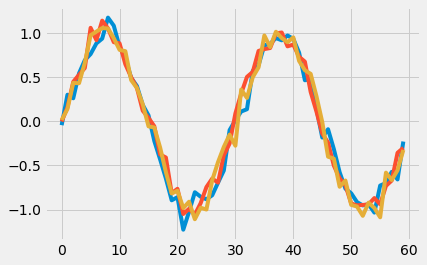

In [402]:
plt.plot(time_index*Nt, males[:,0])
plt.plot(time_index*Nt, males[:,15])
plt.plot(time_index*Nt, males[:,19])
plt.show()

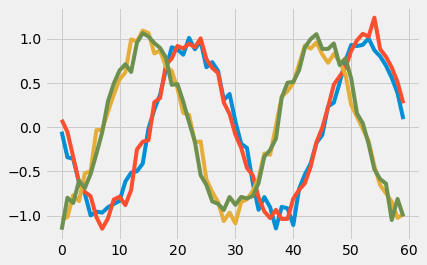

In [418]:
plt.plot(time_index*Nt, females[:,0])
plt.plot(time_index*Nt, females[:,2])
plt.plot(time_index*Nt, females[:,40])
plt.plot(time_index*Nt, females[:,42])
plt.show()

Let's find the average spectra for these groups series (e.g. we could imagine one group is male and one group is female). NOTE: averaging needs to be done AFTER the absolute values are taken, otherwise phase differences will result in constructive and destructive interference and thereby affect our coefficient averages. 

This first part of the analysis will not be dyadic.

In [404]:
f = Fs * np.linspace(0,int(Nt/2), int(Nt/2+1))/Nt

fft_male1 = np.fft.fft(males, axis=0)

fft_male2 = 2*np.abs(fft_male1[0:int(Nt/2)+1]/Nt)

fft_female1 = np.fft.fft(females, axis=0)

fft_female2 = 2*np.abs(fft_female1[0:int(Nt/2)+1]/Nt)
fft_male2.shape


(31, 50)

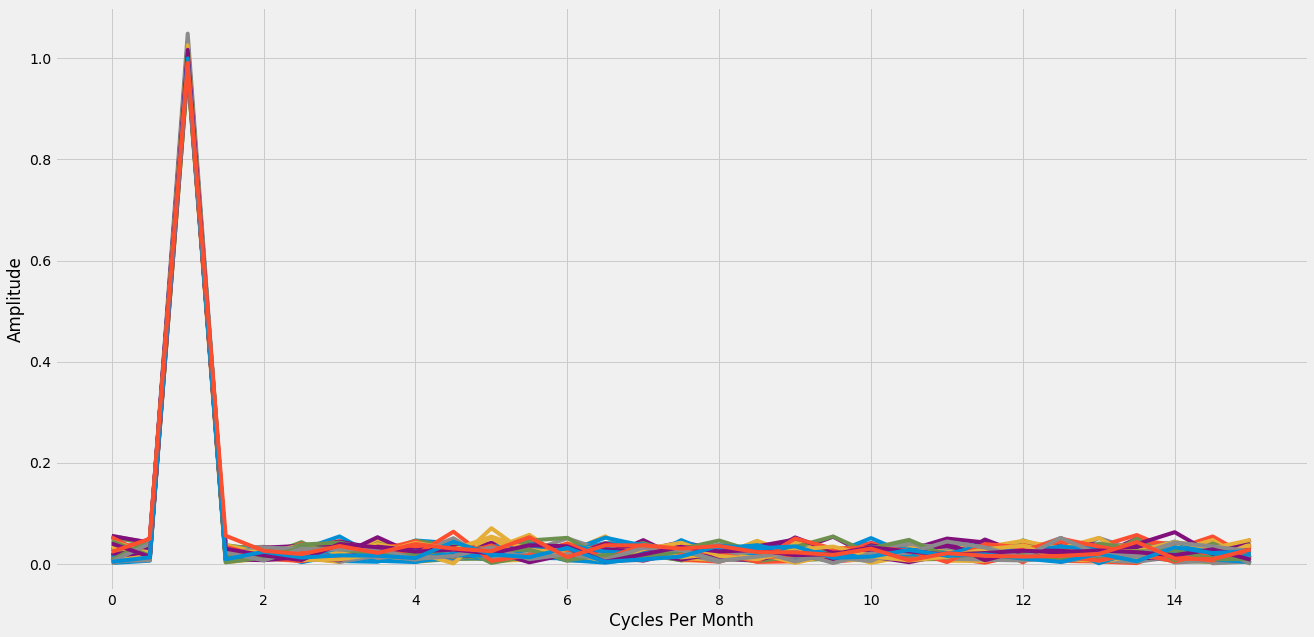

In [405]:
# plot ALL male plots:
plt.figure(figsize=(20,10))
plt.plot(f, fft_male2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

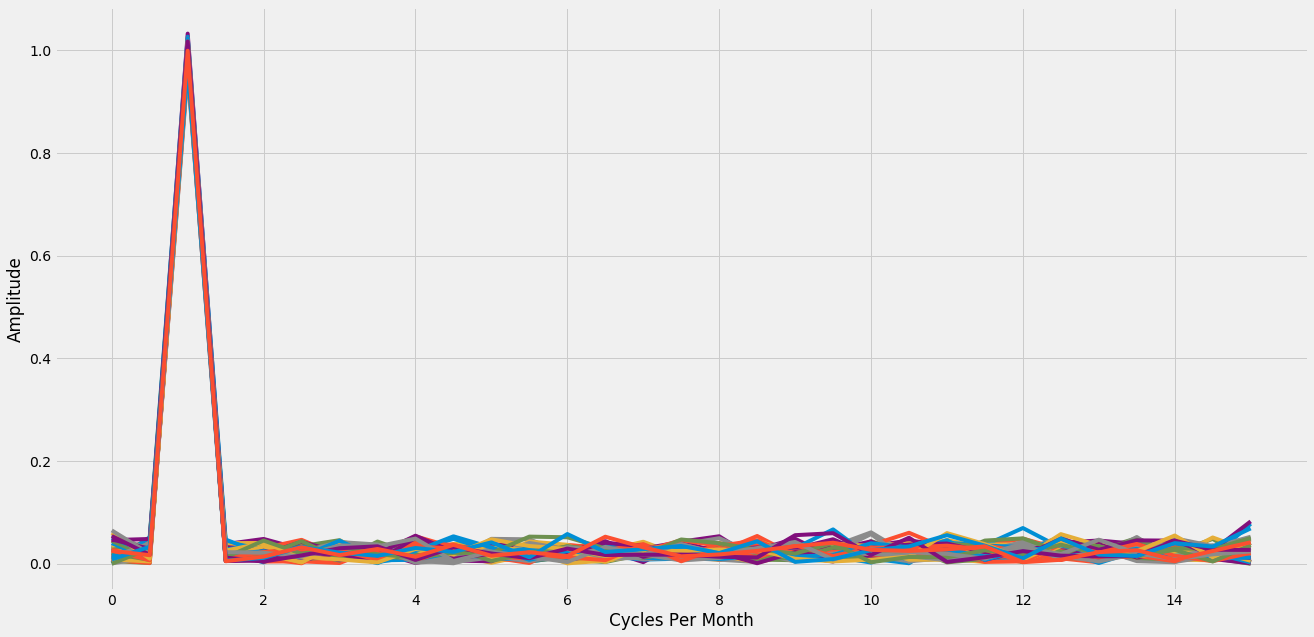

In [406]:
# plot ALL female plots:
plt.figure(figsize=(20,10))
plt.plot(f, fft_female2)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

And now let's average these over male/female participants (i.e. columns) and plot.

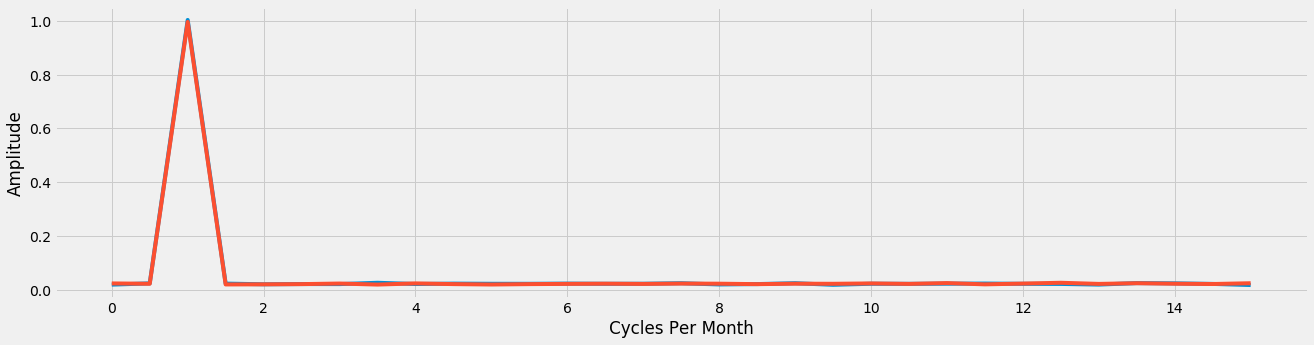

In [407]:
fft_male2_av = np.mean(fft_male2,axis=1)
fft_female2_av = np.mean(fft_female2,axis=1)
plt.figure(figsize=(20, 5))
plt.plot(f, fft_male2_av)
plt.plot(f, fft_female2_av)
plt.xlabel('Cycles Per Month')
plt.ylabel('Amplitude')
plt.show()

Now lets find the average cross spectral plots between COUPLES (i.e. the average CPSD for couples, across all couples).

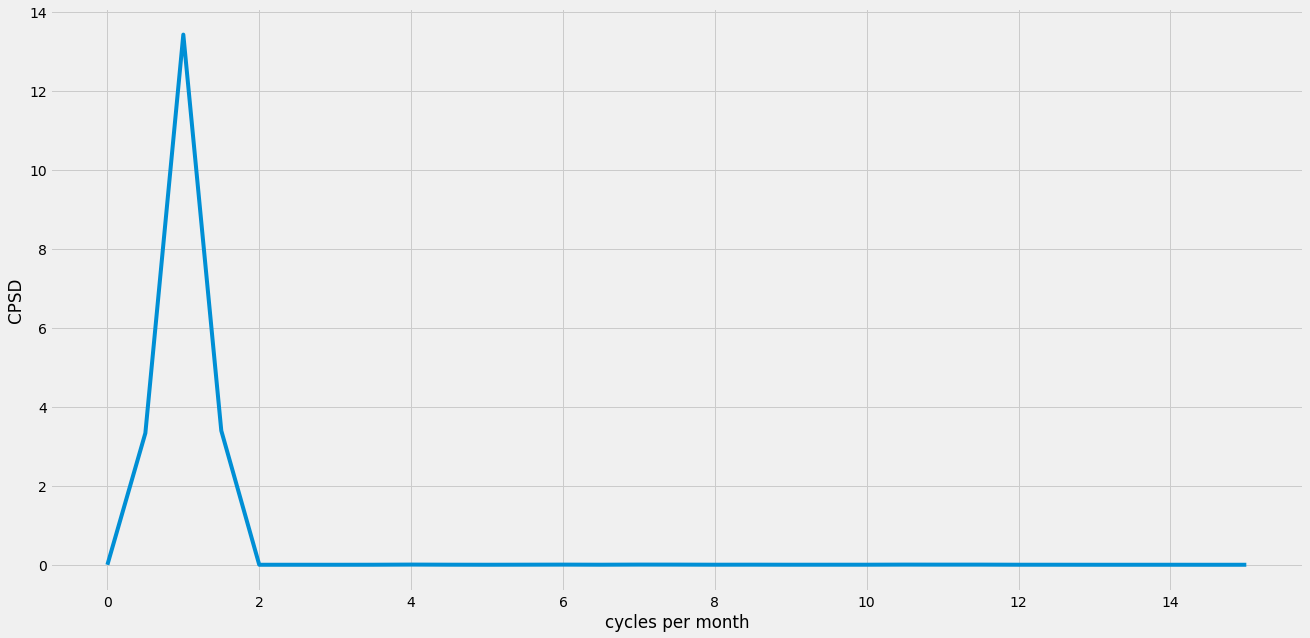

In [408]:
f1, Pxy = signal.csd(males, females, nperseg=Nt, axis=0)

Pxy_mean = np.mean(Pxy, axis=1)

plt.figure(figsize=(20,10))
plt.plot(f, np.abs(Pxy_mean))
plt.xlabel('cycles per month')
plt.ylabel('CPSD')
plt.show()

So far so good, now let's actually look at this phase thing. Remember we split each group of (men and women) into two subgroups - couples that had phase offset x-days, and those with a phase offset of y-days.


In [428]:
fft_male_phase = np.angle(fft_male1[0:int(Nt/2)+1])
fft_female_phase = np.angle(fft_female1[0:int(Nt/2)+1])

# make sure all phase estimates are POSITIVE (i.e. find their equivalent positive phase)

for i in range(fft_male_phase.shape[0]):
    for j in range(fft_male_phase.shape[1]):

        if fft_male_phase[i,j] <=0:
            fft_male_phase[i,j] += 2*np.pi

        if fft_female_phase[i,j] <=0:
            fft_female_phase[i,j] += 2*np.pi

        
male_av_phase = circmean(fft_male_phase, axis=1)
female_av_phase = circmean(fft_female_phase, axis=1) 
# these means tell us the average phase offsets for each frequency (non-dyadic)

cpsd_av_phase = np.angle(Pxy)
for i in range(cpsd_av_phase.shape[0]):
    for j in range(cpsd_av_phase.shape[1]):

        if cpsd_av_phase[i,j] <=0:
            cpsd_av_phase[i,j] += 2*np.pi

couple_av_phase = circmean(cpsd_av_phase, axis=1)
# these means tell us the average phase offsets for each frequency between partners (dyadic)



These means are all well and good... but they don't tell use the distribution across individuals for the specific frequency components that are actually important to us (i.e. once and 4 times per month). For these, we will pull out indices 2 and 8 (indexing from 0 as per python).

In [426]:
freq_1pm_male = fft_male_phase[2,:]
freq_4pm_male = fft_male_phase[8,:]
freq_1pm_female = fft_female_phase[2,:]
freq_4pm_female = fft_female_phase[8,:]



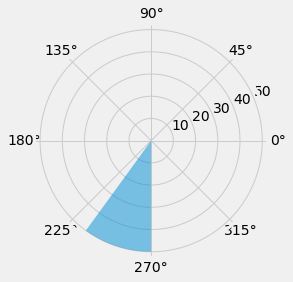

In [411]:
hist_bins = 10  
bins = np.linspace(0, 2 * np.pi, hist_bins + 1)
n, _, _ = plt.hist(freq_1pm_male, bins)

plt.clf()
w = 2 * np.pi / hist_bins
ax = plt.subplot(1, 1, 1, projection='polar')
pmfs = ax.bar(bins[:hist_bins], n, width=w, bottom=0.0)
for bar in pmfs:
    bar.set_alpha(0.5)
plt.show()

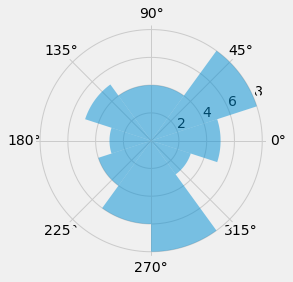

In [412]:
hist_bins = 10  
bins = np.linspace(0, 2 * np.pi, hist_bins + 1)
n, _, _ = plt.hist(freq_4pm_male, bins)

plt.clf()
w = 2 * np.pi / hist_bins
ax = plt.subplot(1, 1, 1, projection='polar')
pmfs = ax.bar(bins[:hist_bins], n, width=w, bottom=0.0)
for bar in pmfs:
    bar.set_alpha(0.5)
plt.show()

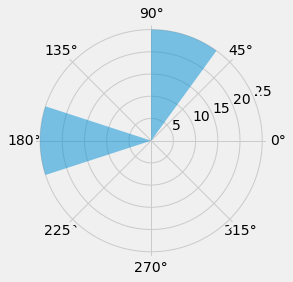

In [413]:
hist_bins = 10  
bins = np.linspace(0, 2 * np.pi, hist_bins + 1)
n, _, _ = plt.hist(freq_1pm_female, bins)

plt.clf()
w = 2 * np.pi / hist_bins
ax = plt.subplot(1, 1, 1, projection='polar')
pmfs = ax.bar(bins[:hist_bins], n, width=w, bottom=0.0)
for bar in pmfs:
    bar.set_alpha(0.5)
plt.show()

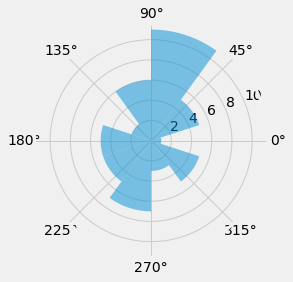

In [414]:
hist_bins = 10  
bins = np.linspace(0, 2 * np.pi, hist_bins + 1)
n, _, _ = plt.hist(freq_4pm_female, bins)

plt.clf()
w = 2 * np.pi / hist_bins
ax = plt.subplot(1, 1, 1, projection='polar')
pmfs = ax.bar(bins[:hist_bins], n, width=w, bottom=0.0)
for bar in pmfs:
    bar.set_alpha(0.5)
plt.show()

These results can be fairly arbitrary and really depend on when each individual started participating with respect to their own cycle(s). What is more interesting is to look at the CPSD phase (i.e. dyadic discrepancies) assuming that each COUPLE started participating at the same time.

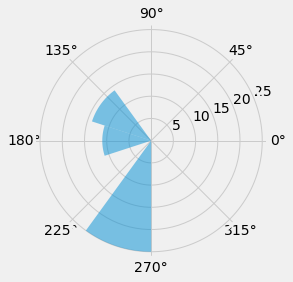

In [415]:
cpsd_av_phase_1pm = cpsd_av_phase[2,:]
cpsd_av_phase_4pm = cpsd_av_phase[8,:]

hist_bins = 10  
bins = np.linspace(0, 2 * np.pi, hist_bins + 1)
n, _, _ = plt.hist(cpsd_av_phase_1pm, bins)

plt.clf()
w = 2 * np.pi / hist_bins
ax = plt.subplot(1, 1, 1, projection='polar')
pmfs = ax.bar(bins[:hist_bins], n, width=w, bottom=0.0)
for bar in pmfs:
    bar.set_alpha(0.5)
plt.show()

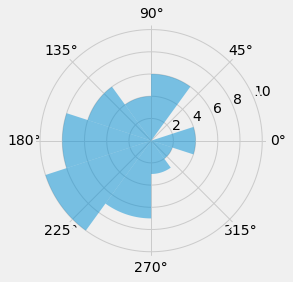

In [416]:
hist_bins = 10  
bins = np.linspace(0, 2 * np.pi, hist_bins + 1)
n, _, _ = plt.hist(cpsd_av_phase_4pm, bins)

plt.clf()
w = 2 * np.pi / hist_bins
ax = plt.subplot(1, 1, 1, projection='polar')
pmfs = ax.bar(bins[:hist_bins], n, width=w, bottom=0.0)
for bar in pmfs:
    bar.set_alpha(0.5)
plt.show()

Note that the polar histograms are for specific frequencies. If we want to find out what the phase discrepancy corresponds to, we need to know the frequency, and the phase. e.g. for the one above, this is a frequency of 4 times per month, or a period of 7 days, and one the phase discrepancies is approximately 300 degrees. We can do $300/360 * 7 = 5.8$ days discrepancy. The one other thing to be mindful of is the fact that we can understand this as leading OR lagging. 

In [417]:
360*cpsd_av_phase_4pm / (2*np.pi)

array([ 98.56694221, 208.08418523, 237.75968185, 222.51051762,
       246.13268987, 293.16315672,  98.43085206, 137.28026996,
       263.33821551,  19.62114826, 205.39097477, 241.33603463,
       236.94654336,  19.73181591, 211.21180517, 217.12372124,
       297.90448195, 318.93002889, 265.83293736, 184.17586112,
       284.57259101, 156.45542551,  99.00411428,  89.74815881,
       270.26635073,   5.25205847, 128.58323211, 150.07758062,
       244.12619082, 172.39720012, 167.18447451, 207.40324625,
        88.68576517, 157.38314539, 247.08229258, 212.25758363,
       133.0033541 ,  74.60316378, 334.89713144, 212.3504428 ,
       272.42871877, 349.90880501, 112.11874379,   0.65943993,
       253.45276002, 224.15067491, 197.47422002, 261.21946902,
       218.49554839, 174.81095802])

In [357]:
(7*300)/360

5.833333333333333

In [ ]:
cpsd_av_phase_4pm